#### Dependencies #### 


In [1]:
import pandas as pd, numpy as np, os, sys, seaborn as sns, matplotlib.pyplot as plt 

sys.path.append('./')
sys.path.append('../')
sys.path.append('../../')


# load ing arff files 
from scipy.io import arff


#### GLobals #### 


In [1]:

DATAPATH = os.path.join("./data/","ThoraricSurgery.arff")


NameError: name 'os' is not defined

#### Background #### 

#### Data source ####



Kaggle: https://www.kaggle.com/datasets/sid321axn/thoraric-surgery/data

The original (and better) curated dataset can be retrieved from here
https://archive.ics.uci.edu/dataset/277/thoracic+surgery+data

1. DGN: Diagnosis - specific combination of ICD-10 codes for primary and secondary as well multiple tumours if any (DGN3,DGN2,DGN4,DGN6,DGN5,DGN8,DGN1)
2. PRE4: Forced vital capacity - FVC (numeric)
3. PRE5: Volume that has been exhaled at the end of the first second of forced expiration - FEV1 (numeric)
4. PRE6: Performance status - Zubrod scale (PRZ2,PRZ1,PRZ0)
5. PRE7: Pain before surgery (T,F)
6. PRE8: Haemoptysis before surgery (T,F)
7. PRE9: Dyspnoea before surgery (T,F)
8. PRE10: Cough before surgery (T,F)
9. PRE11: Weakness before surgery (T,F)
10. PRE14: T in clinical TNM - size of the original tumour, from OC11 (smallest) to OC14 (largest) (OC11,OC14,OC12,OC13)
11. PRE17: Type 2 DM - diabetes mellitus (T,F)
12. PRE19: MI up to 6 months (T,F)
13. PRE25: PAD - peripheral arterial diseases (T,F)
14. PRE30: Smoking (T,F)
15. PRE32: Asthma (T,F)
16. AGE: Age at surgery (numeric)
17. Risk1Y: 1 year survival period - (T)rue value if died (T,F)


## Content ##
The data is dedicated to classification problem related to the post-operative life expectancy in the lung cancer patients after thoracic surgery in 
which there are two classes class 1 - the death of patients within one year after surgery and class 2 – the patients who survive.
The data was collected retrospectively at Wroclaw Thoracic Surgery Centre for patients who underwent major lung resections for 
primary lung cancer in the years 2007 to 2011. The Centre is associated with the Department of Thoracic Surgery of the Medical University of 
Wroclaw and Lower-Silesian Centre for Pulmonary Diseases, Poland, while the research database constitutes a part of the National Lung Cancer 
Registry, administered by the Institute of Tuberculosis and Pulmonary Diseases in Warsaw, Poland.

Globals

In [3]:
# kaggle DATAPATH =  os.path.join(".//data//","ThoraricSurgery.csv")  

# original dataset. 
# DATAPATH =  os.path.join(".//data//","ThoraricSurgery.arff")  

# Load datset 

In [3]:
def preprocess_dataset_types( df ):

    # give the columns a mnore meaningful name based on the dataset description 
    column_names = {'DGN': 'diagnosis',
                    'PRE4': 'fvc',
                    'PRE5': 'fev1',
                    'PRE6': 'performance', 
                    'PRE7': 'pain',
                    'PRE8': 'haemoptysis', 
                    'PRE9': 'dyspnoea',
                    'PRE10': 'cough',
                    'PRE11': 'weakness',
                    'PRE14': 'tumor_size', #from OC11 (smallest) to OC14 (largest) (OC11,OC14,OC12,OC13)
                    'PRE17': 'diabetes', 
                    'PRE19': 'mi_6months',
                    'PRE25': 'pad', 
                    'PRE30': 'smoking', 
                    'PRE32': 'asthma',
                    'AGE': 'age',
                    'Risk1Yr': 'target'
    }

    df.rename( column_names, inplace = True, axis = 1 )
    columns = df.columns 

    # all those bytes need to be converted to str 
    # and then potentially to other types 
    numeric_columns = df.select_dtypes( np.number )
    str_df = df.select_dtypes([object])
    str_df = str_df.stack().str.decode('utf-8').unstack()

    for col in numeric_columns.columns: 
        str_df[col] = numeric_columns[col].values 

    # keep the origuinal order of the columnns 
    str_df = str_df[  columns ]


    # process the data types based on description 
    bool_columns= list(set( str_df.columns ).difference( ['diagnosis','fvc', 'fev1', 'performance','tumor_size', 'age'] ))
    str_df[ bool_columns ] = str_df[ bool_columns ].apply( lambda x: np.where( x == 'F',  False, np.where( x == 'T', True, x )))
    str_df[ bool_columns ] = str_df[bool_columns].astype( np.int32 ) 

    str_df['tumor_size'] = str_df['tumor_size'].str[-2:].astype( np.int32 )
    str_df['performance'] = str_df['performance'].str[-1:].astype( np.int32 )
    str_df['diagnosis'] = str_df['diagnosis'].str[-1:].astype( np.int32 )

    float_columns = ['fvc', 'fev1','age'] 
    str_df[ float_columns ] = str_df[ float_columns ].astype( np.float32 )

    str_df['target'] = str_df['target'].astype( np.int32 )


    return str_df 
    
 


In [4]:
df = pd.DataFrame(arff.loadarff(DATAPATH)[0])
display( ' raw data', df.sample(5))
print( 50*'-')

df = preprocess_dataset_types(  df )   
display( ' pre-processed', df.head( 5 ) )
display( round( df.describe(),2) ) 
display( pd.DataFrame( df.dtypes ).T ) 
print( ' Null values',df.isnull().sum().any()  )   
print( ' Duplicates ? ', df[df.duplicated()].sum().any() )

numerical_features = ['fvc', 'fev1', 'age' ]
categorical_features = list( set( df.columns ).difference( numerical_features ))
categorical_features.remove('target') 
ordinal_features = ['performance', 'tumor_size']  # ?diagnosis 
nominal_features = ['diagnosis',  'haemoptysis', 'dyspnoea', 'mi_6months', 'diabetes', 'weakness', 'pain', 'asthma', 'smoking', 'pad', 'cough']

print() 
print(' continuous features ', numerical_features )
print(' discrete features ', categorical_features ) 
print(' ordinal features ', ordinal_features ); print (' ?diagnosis ordinal ')
print(' nominal features ', nominal_features );  


' raw data'

,DGN,PRE4,PRE5,PRE6,PRE7,PRE8,PRE9,PRE10,PRE11,PRE14,PRE17,PRE19,PRE25,PRE30,PRE32,AGE,Risk1Yr
267,b'DGN3',3.32,2.92,b'PRZ2',b'F',b'F',b'F',b'T',b'T',b'OC13',b'F',b'F',b'F',b'T',b'F',63.0,b'F'
1,b'DGN3',3.40,1.88,b'PRZ0',b'F',b'F',b'F',b'F',b'F',b'OC12',b'F',b'F',b'F',b'T',b'F',51.0,b'F'
269,b'DGN3',4.28,3.28,b'PRZ1',b'T',b'F',b'F',b'T',b'F',b'OC11',b'F',b'F',b'F',b'T',b'F',71.0,b'F'
367,b'DGN5',2.38,1.72,b'PRZ1',b'F',b'T',b'F',b'T',b'F',b'OC12',b'T',b'F',b'T',b'T',b'F',87.0,b'T'
126,b'DGN3',4.56,2.68,b'PRZ1',b'F',b'F',b'F',b'T',b'F',b'OC11',b'F',b'F',b'F',b'T',b'F',62.0,b'F'


--------------------------------------------------


' pre-processed'

,diagnosis,fvc,fev1,performance,pain,haemoptysis,dyspnoea,cough,weakness,tumor_size,diabetes,mi_6months,pad,smoking,asthma,age,target
0,2,2.88,2.16,1,0,0,0,1,1,14,0,0,0,1,0,60.0,0
1,3,3.40,1.88,0,0,0,0,0,0,12,0,0,0,1,0,51.0,0
2,3,2.76,2.08,1,0,0,0,1,0,11,0,0,0,1,0,59.0,0
3,3,3.68,3.04,0,0,0,0,0,0,11,0,0,0,0,0,54.0,0
4,3,2.44,0.96,2,0,1,0,1,1,11,0,0,0,1,0,73.0,1


,diagnosis,fvc,fev1,performance,pain,haemoptysis,dyspnoea,cough,weakness,tumor_size,diabetes,mi_6months,pad,smoking,asthma,age,target
count,470.00,470.00,470.00,470.00,470.00,470.00,470.00,470.00,470.00,470.00,470.00,470.00,470.00,470.00,470.00,470.00,470.00
mean,3.10,3.28,4.57,0.78,0.07,0.14,0.07,0.69,0.17,11.74,0.07,0.00,0.02,0.82,0.00,62.53,0.15
std,0.72,0.87,11.77,0.54,0.25,0.35,0.25,0.46,0.37,0.70,0.26,0.07,0.13,0.38,0.07,8.71,0.36
min,1.00,1.44,0.96,0.00,0.00,0.00,0.00,0.00,0.00,11.00,0.00,0.00,0.00,0.00,0.00,21.00,0.00
25%,3.00,2.60,1.96,0.00,0.00,0.00,0.00,0.00,0.00,11.00,0.00,0.00,0.00,1.00,0.00,57.00,0.00
50%,3.00,3.16,2.40,1.00,0.00,0.00,0.00,1.00,0.00,12.00,0.00,0.00,0.00,1.00,0.00,62.00,0.00
75%,3.00,3.81,3.08,1.00,0.00,0.00,0.00,1.00,0.00,12.00,0.00,0.00,0.00,1.00,0.00,69.00,0.00
max,8.00,6.30,86.30,2.00,1.00,1.00,1.00,1.00,1.00,14.00,1.00,1.00,1.00,1.00,1.00,87.00,1.00


,diagnosis,fvc,fev1,performance,pain,haemoptysis,dyspnoea,cough,weakness,tumor_size,diabetes,mi_6months,pad,smoking,asthma,age,target
0,int32,float32,float32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,float32,int32


 Null values False
 Duplicates ?  False

 continuous features  ['fvc', 'fev1', 'age']
 discrete features  ['cough', 'mi_6months', 'smoking', 'pad', 'diabetes', 'performance', 'diagnosis', 'pain', 'dyspnoea', 'haemoptysis', 'tumor_size', 'weakness', 'asthma']
 ordinal features  ['performance', 'tumor_size']
 ?diagnosis ordinal 
 nominal features  ['diagnosis', 'haemoptysis', 'dyspnoea', 'mi_6months', 'diabetes', 'weakness', 'pain', 'asthma', 'smoking', 'pad', 'cough']


In [18]:
def plot_distribution_and_intervals(data, bounds = None, title="",figsize= (20,3 )):

  df = data.select_dtypes(np.number)
  fig, ax = plt.subplots( nrows = 1, ncols = df.shape[1] , figsize= figsize )

  for n,col in enumerate(df.columns):
    a = sns.histplot( df[col],  ax = ax[n], cumulative=False )
    a.set_ylabel(None)

    if bounds is not None:
      if not col in bounds.index:
        continue
      x1,x2 = bounds.loc[col,'lower bound'], bounds.loc[col,'upper bound']
      y1, y2 = a.get_ylim()[0] - a.get_ylim()[1]*0.01 , a.get_ylim()[1]
      a.vlines( x = x1, ymin = y1, ymax = y2, color = 'red' )
      a.vlines( x = x2, ymin = y1, ymax = y2, color = 'red' )

  fig.suptitle(title)
  plt.show()


# plot_distribution_and_intervals( df.select_dtypes( np.float32 ) , bounds = iqr_df, title="",figsize= (20,3 ))
# _= sns.pairplot( df[numerical_features ], diag_kind='kde' )

In [5]:
def compute_iqr_ouliers( df, scale = 1.5  ):
    X = df.select_dtypes( np.number ) 

    q1,q3 =   X.quantile(0.25), X.quantile(0.75)
    iqr = q3 - q1
    iqr_min =  q1 - scale*iqr
    iqr_max =  q3 + scale*iqr

    #mask table true/false
    outliers_df = (X > iqr_max) |  (X < iqr_min)

    #bounds table
    iqr_df = pd.concat( [iqr, q1,q3, iqr_min, iqr_max],axis= 1)
    iqr_df.columns = ['IQR', 'Q1','Q3','lower bound', 'upper bound']
    median = pd.DataFrame( X.median(), columns =['median'] )
    iqr_df =  pd.concat( [median, iqr_df], axis= 1  )
    count = pd.DataFrame( outliers_df.sum(), columns =['outliers'] )
    iqr_df = pd.concat( [iqr_df,count], axis = 1)
    return iqr_df 


def remove_outliers( df,bounds ):
    print(' initial num rows ', df.shape[0])
    for name in bounds.index:
        low, high = bounds.loc[name]['lower bound'], bounds.loc[name]['upper bound']
        df = df[ (df[name] > low) & (df[name] < high)]

    print(' final num rows ', df.shape[0])
    return df 



X = df[ numerical_features ]
iqr_df = compute_iqr_ouliers( X, scale = 1.7  )
display( iqr_df )

df = remove_outliers(  df, iqr_df )
df.describe() 

,median,IQR,Q1,Q3,lower bound,upper bound,outliers
fvc,3.16,1.2075,2.60,3.8075,0.54725,5.86025,2
fev1,2.40,1.1200,1.96,3.0800,0.05600,4.98400,16
age,62.00,12.0000,57.00,69.0000,36.60000,89.40000,1


 initial num rows  470
 final num rows  452


,diagnosis,fvc,fev1,performance,pain,haemoptysis,dyspnoea,cough,weakness,tumor_size,diabetes,mi_6months,pad,smoking,asthma,age,target
count,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000
mean,3.090708,3.275111,2.504978,0.798673,0.059735,0.137168,0.055310,0.699115,0.172566,11.736726,0.075221,0.004425,0.017699,0.829646,0.004425,62.845131,0.152655
std,0.716113,0.852524,0.752357,0.529986,0.237257,0.344406,0.228837,0.459151,0.378291,0.707374,0.264040,0.066445,0.132002,0.376360,0.066445,8.405093,0.360053
min,1.000000,1.440000,0.960000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.000000,0.000000,0.000000,0.000000,0.000000,0.000000,37.000000,0.000000
25%,3.000000,2.600000,1.960000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.000000,0.000000,0.000000,0.000000,1.000000,0.000000,57.000000,0.000000
50%,3.000000,3.160000,2.360000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,12.000000,0.000000,0.000000,0.000000,1.000000,0.000000,62.000000,0.000000
75%,3.000000,3.817500,2.962500,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,12.000000,0.000000,0.000000,0.000000,1.000000,0.000000,69.250000,0.000000
max,8.000000,5.600000,4.960000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,14.000000,1.000000,1.000000,1.000000,1.000000,1.000000,87.000000,1.000000


In [6]:
symptoms = ['weakness','pad', 'dyspnoea', 'smoking', 'haemoptysis','pain','diabetes', 'cough' ] 
x = df[ symptoms ].sum( axis = 1 )
df['symptoms_count'] = x 
df['cal'] = df['fvc']/df['fev1'] 


symptoms_count
0    0.076923
1    0.066667
2    0.152174
3    0.186275
4    0.344828
5    0.500000
Name: target, dtype: float64

test_precision 0.25
test_recall 0.6521739130434783
test_f1 0.3614457831325301
test_accuracy 0.6466666666666666


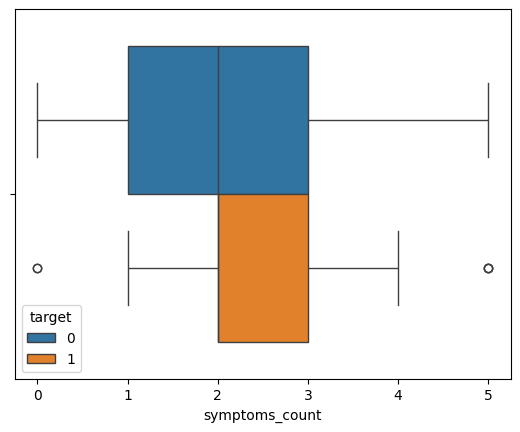

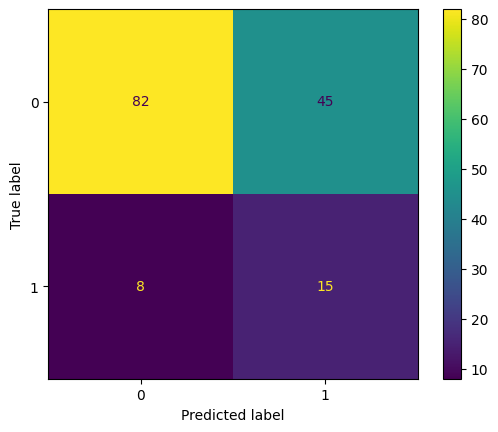

In [105]:
x =df.groupby( 'symptoms_count')['target'].mean()
display( x )
_=sns.boxplot( data = df, x = 'symptoms_count', hue = 'target' )

# first dummy model 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score

y,X = df['target'], df.drop( ['target', 'symptoms_count'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True,  
                                                    test_size=0.33, 
                                                    random_state=12, 
                                                    stratify = y)


logistic_vanilla= LogisticRegression(random_state=10, class_weight= 'balanced',  penalty='l2',  max_iter =2500 )
logistic_vanilla.fit(X_train, y_train)
logistic_vanilla_pred = logistic_vanilla.predict( X_test )
 
m = confusion_matrix(y_test, logistic_vanilla_pred)
ConfusionMatrixDisplay(confusion_matrix=m,display_labels=logistic_vanilla.classes_).plot()

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

print( 'test_precision' , precision_score( y_test, logistic_vanilla_pred) )
print( 'test_recall', recall_score( y_test, logistic_vanilla_pred) )
print( 'test_f1', f1_score( y_test, logistic_vanilla_pred) )
print( 'test_accuracy' , accuracy_score( y_test, logistic_vanilla_pred) )
 


[0.23333333 0.25714286 0.34615385 0.16666667 0.20512821] 0.24168498168498168
[0.5        0.64285714 0.69230769 0.42857143 0.57142857] 0.567032967032967
[0.31818182 0.36734694 0.46153846 0.24       0.30188679] 0.33779080218972396
[0.67032967 0.65934066 0.76666667 0.57777778 0.58888889] 0.6526007326007327


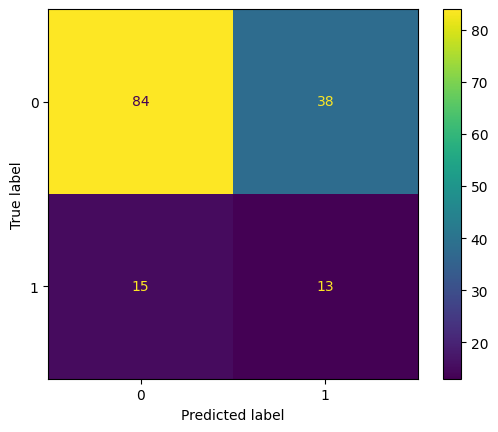

In [104]:

df2 = df[df['symptoms_count'] > -3 ].copy()
#df2.drop( [ 'fvc', 'asthma', 'cough','mi_6months','smoking','pad' ], axis = 1, inplace=True)
#df2['age'] = (df2['age']/10).astype(int)
#df2 = df2[ ['diagnosis','fvc','diabetes', 'weakness', 'tumor_size', 'target'] ]
y,X = df2['target'], df2.drop( ['target'], axis = 1)



X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True,  
                                                    test_size=0.33, 
                                                    random_state=12, 
                                                    
                                                    #stratify = y
                                                    )
logistic_vanilla= LogisticRegression(random_state=10, class_weight='balanced', penalty=None,  max_iter =1000 )
logistic_vanilla.fit(X_train, y_train)
logistic_vanilla_pred = logistic_vanilla.predict( X_test )

m = confusion_matrix(y_test, logistic_vanilla_pred)
ConfusionMatrixDisplay(confusion_matrix=m,display_labels=logistic_vanilla.classes_).plot()


logistic_vanilla= LogisticRegression(random_state=10, class_weight='balanced', penalty=None,  max_iter =1000 )
cv_results = cross_validate(logistic_vanilla, X, y, scoring=['precision','recall','f1', 'accuracy'], cv=5)

print(cv_results['test_precision'], cv_results['test_precision'].mean())
print(cv_results['test_recall'], cv_results['test_recall'].mean())
print(cv_results['test_f1'], cv_results['test_f1'].mean())
print(cv_results['test_accuracy'], cv_results['test_accuracy'].mean())
 



In [62]:
from sklearn.feature_selection import SelectKBest, f_classif, chi2, mutual_info_classif
 

y,X = df2['target'], df2.drop( ['target'] , axis = 1  )
kbest = SelectKBest(chi2, k='all')
_= kbest.fit( X, y )
importance = pd.DataFrame( {'Feature': X.columns, 'chi2 score':kbest.scores_, 'pvalues': kbest.pvalues_})
importance.sort_values( by = 'chi2 score', ascending=False) 

,Feature,chi2 score,pvalues
8,diabetes,1.426891,0.232272
4,haemoptysis,0.653992,0.418689
5,dyspnoea,0.566434,0.451680
11,cal,0.346464,0.556122
1,fev1,0.258441,0.611193
0,diagnosis,0.178798,0.672408
3,pain,0.037296,0.846864
2,performance,0.036713,0.848050
9,age,0.024968,0.874447
10,symptoms_count,0.017459,0.894881


In [63]:
df2#.sort_values( by = 'age')

,diagnosis,fev1,performance,pain,haemoptysis,dyspnoea,weakness,tumor_size,diabetes,age,target,symptoms_count,cal
4,3,0.96,2,0,1,0,1,11,0,7,1,4,2.541667
52,3,2.52,2,1,1,1,0,12,0,6,0,5,1.269841
57,3,2.80,1,1,0,0,1,11,1,6,1,5,1.214286
67,4,1.76,1,0,1,0,1,11,0,6,1,4,1.318182
88,5,1.76,2,0,1,0,1,11,0,7,0,4,1.522727
99,3,2.92,1,0,1,1,0,12,0,5,1,4,1.575342
101,3,1.64,1,0,0,0,1,12,1,7,0,4,1.121951
115,4,1.76,1,0,1,0,0,11,1,6,1,4,1.568182
127,3,1.00,1,0,1,0,1,11,1,7,1,5,2.000000
158,3,2.32,1,0,1,0,1,12,0,6,0,5,1.327586


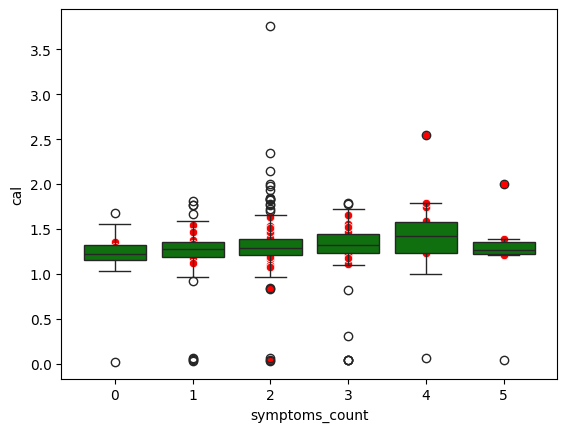

In [87]:
df['cal'] = df['fvc']/df['fev1'] 

name1, name2 =  'symptoms_count', 'cal'


#a =sns.histplot( data = df, x = name1, y = name2)#, ax = ax[n]  )

anomalies = df#[ df['target'] == 0 ]
_=sns.boxplot( data = anomalies, x = name1, y = name2,    color='green', legend = False )

anomalies = df[ df['target'] == 1 ]
_=sns.scatterplot( data = anomalies, x = name1, y = name2,     color='red', legend = False )


#plt.ylim(0.4,6)


<Axes: ylabel='symptoms_count'>

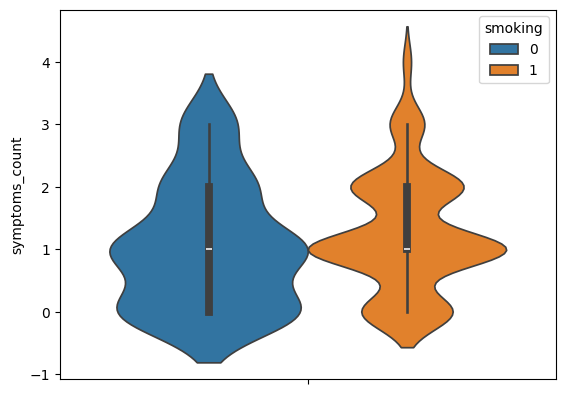

In [77]:
sns.violinplot( data = df, y ='symptoms_count', hue = 'smoking' ) 

In [45]:
x = df[ df['target'] == 1 ]#.head(50)
#x = x[ x['fev1'] >  20  ].head(50)

x

,diagnosis,fvc,fev1,performance,pain,haemoptysis,dyspnoea,cough,weakness,tumor_size,diabetes,mi_6months,pad,smoking,asthma,age,target,cal
4,3,2.44,0.96,2,0,1,0,1,1,11,0,0,0,1,0,73.0,1,2.541667
6,3,4.36,3.28,1,0,0,0,1,0,12,1,0,0,1,0,59.0,1,1.329268
7,2,3.19,2.50,1,0,0,0,1,0,11,0,0,1,1,0,66.0,1,1.276000
13,2,3.98,3.06,2,0,0,0,1,1,14,0,0,0,1,0,80.0,1,1.300654
24,8,4.32,3.20,0,0,0,0,0,0,11,0,0,0,0,0,58.0,1,1.350000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420,5,4.96,4.16,1,0,0,0,1,0,11,0,0,0,1,0,62.0,1,1.192308
421,2,3.76,2.96,1,0,0,0,1,0,14,1,0,0,0,0,64.0,1,1.270270
426,3,2.48,2.08,1,0,0,0,1,0,13,0,0,0,1,0,54.0,1,1.192308
449,3,2.84,1.88,1,0,0,0,1,0,12,0,0,0,1,0,53.0,1,1.510638


# Outliers removal  

,median,IQR,Q1,Q3,lower bound,upper bound,outliers
fvc,3.16,1.2075,2.60,3.8075,0.54725,5.86025,2
fev1,2.40,1.1200,1.96,3.0800,0.05600,4.98400,16
age,62.00,12.0000,57.00,69.0000,36.60000,89.40000,1


 initial num rows  470
 final num rows  452


,diagnosis,fvc,fev1,performance,pain,haemoptysis,dyspnoea,cough,weakness,tumor_size,diabetes,mi_6months,pad,smoking,asthma,age,target
count,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000
mean,3.090708,3.275111,2.504978,0.798673,0.059735,0.137168,0.055310,0.699115,0.172566,11.736726,0.075221,0.004425,0.017699,0.829646,0.004425,62.845131,0.152655
std,0.716113,0.852524,0.752357,0.529986,0.237257,0.344406,0.228837,0.459151,0.378291,0.707374,0.264040,0.066445,0.132002,0.376360,0.066445,8.405093,0.360053
min,1.000000,1.440000,0.960000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.000000,0.000000,0.000000,0.000000,0.000000,0.000000,37.000000,0.000000
25%,3.000000,2.600000,1.960000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.000000,0.000000,0.000000,0.000000,1.000000,0.000000,57.000000,0.000000
50%,3.000000,3.160000,2.360000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,12.000000,0.000000,0.000000,0.000000,1.000000,0.000000,62.000000,0.000000
75%,3.000000,3.817500,2.962500,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,12.000000,0.000000,0.000000,0.000000,1.000000,0.000000,69.250000,0.000000
max,8.000000,5.600000,4.960000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,14.000000,1.000000,1.000000,1.000000,1.000000,1.000000,87.000000,1.000000


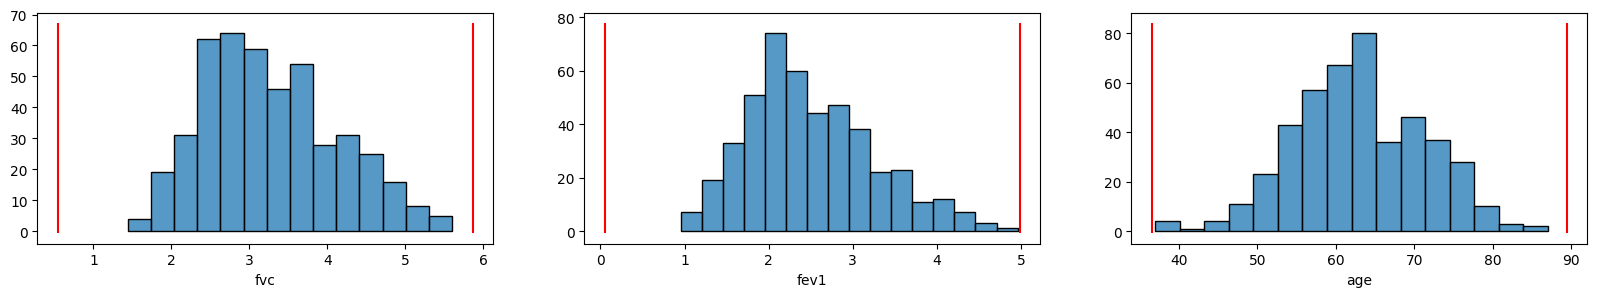

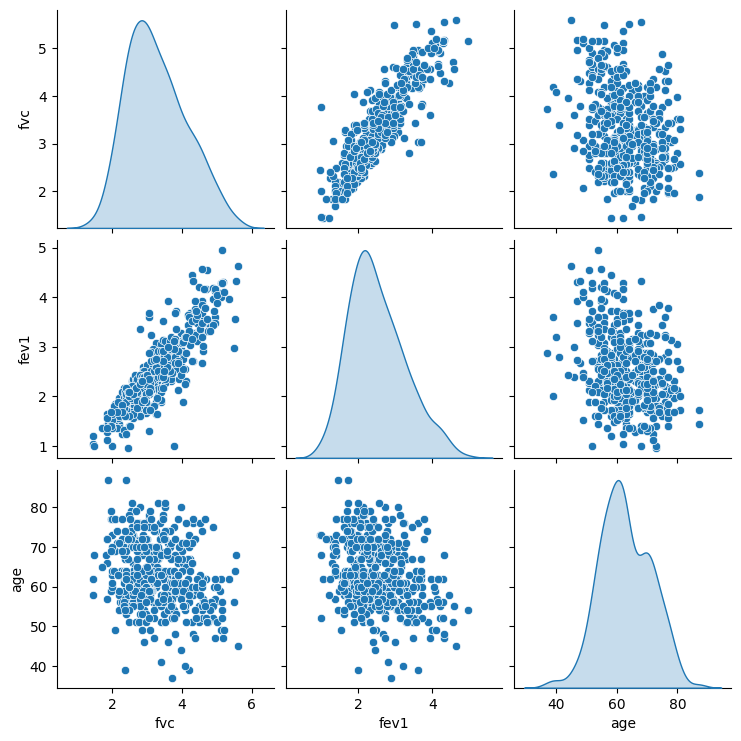

/tmp/ipykernel_1063/2530351846.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  _=df[ categorical_features ].hist( bins = 50, ax= ax )


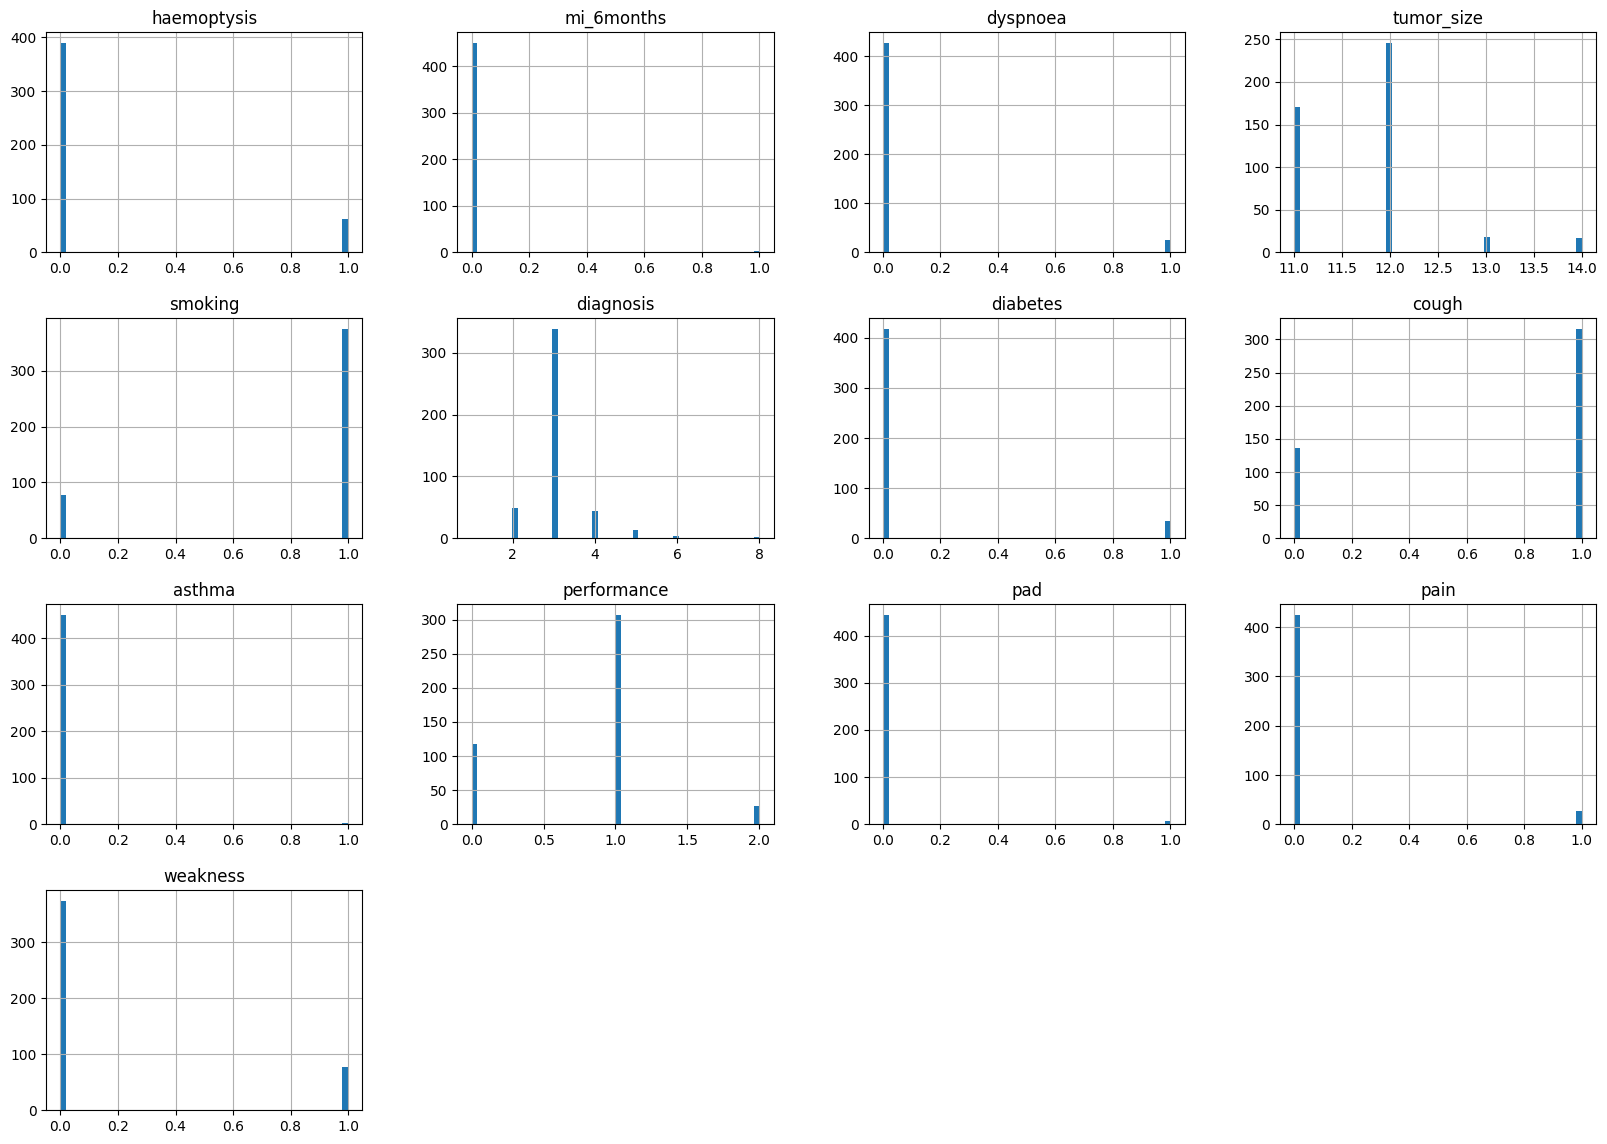

In [9]:
fig,ax = plt.subplots( figsize = (20,14))
_=df[ categorical_features ].hist( bins = 50, ax= ax )
plt.show() 



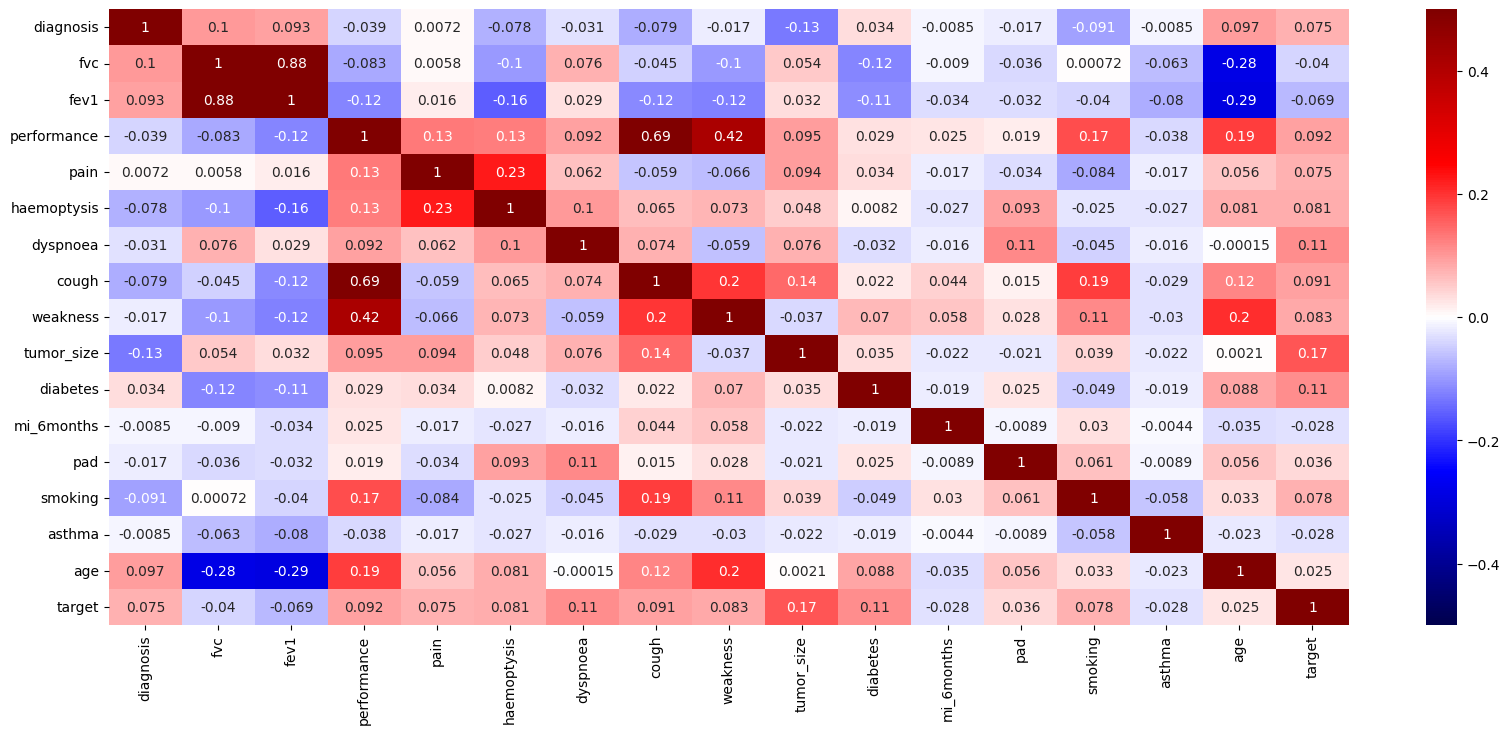

In [10]:

fig,ax = plt.subplots( figsize = (20,8))
_=sns.heatmap( df.corr(), cmap = 'seismic', vmin=-0.5, vmax= 0.5, annot = True  ) 


In [5]:
from sklearn.feature_selection import SelectKBest, f_classif, chi2, mutual_info_classif

#df['cal'] = df['fev1'] / df['fvc']

y,X = df['target'], df.drop( ['target'] , axis = 1  )
kbest = SelectKBest(chi2, k='all')
_= kbest.fit( X, y )
importance = pd.DataFrame( {'Feature': X.columns, 'chi2 score':kbest.scores_, 'pvalues': kbest.pvalues_})
importance.sort_values( by = 'chi2 score', ascending=False) 

,Feature,chi2 score,pvalues
2,fev1,26.090611,3.257643e-07
10,diabetes,5.165816,2.303563e-02
6,dyspnoea,4.888940,2.702927e-02
8,weakness,2.930815,8.690361e-02
5,haemoptysis,1.739706,1.871761e-01
3,performance,1.495368,2.213855e-01
4,pain,1.445161,2.293060e-01
7,cough,1.160725,2.813152e-01
15,age,0.860434,3.536174e-01
12,pad,0.644643,4.220345e-01


In [6]:
from sklearn.feature_selection import SelectKBest, f_classif, chi2, mutual_info_classif

y,X = df['target'], df[numerical_features ]
kbest = SelectKBest(f_classif, k='all')
_= kbest.fit( X, y )
importance = pd.DataFrame( {'Feature': X.columns, 'f score':kbest.scores_, 'pvalues': kbest.pvalues_})
importance.sort_values( by = 'f score', ascending=False) 

,Feature,f score,pvalues
0,fvc,1.008960,0.315671
1,fev1,0.860511,0.354074
2,age,0.708569,0.400349


In [13]:
print( nominal_features )

# only categorical 
X = df[ nominal_features ]
pd.DataFrame( { 'feature': nominal_features, 'mi': mutual_info_classif(X, y, discrete_features=True )} ).sort_values( by ='mi',ascending=False)
#from sklearn.feature_selection import f_classif
#X, y = load_iris(return_X_y=True)
#X.shape
#(150, 4)



['diagnosis', 'haemoptysis', 'dyspnoea', 'mi_6months', 'diabetes', 'weakness', 'pain', 'asthma', 'smoking', 'pad', 'cough']


,feature,mi
0,diagnosis,0.018730
4,diabetes,0.005294
2,dyspnoea,0.005182
10,cough,0.004377
8,smoking,0.003370
5,weakness,0.003179
1,haemoptysis,0.002999
6,pain,0.002422
3,mi_6months,0.000735
7,asthma,0.000735


<Axes: xlabel='weakness', ylabel='target'>

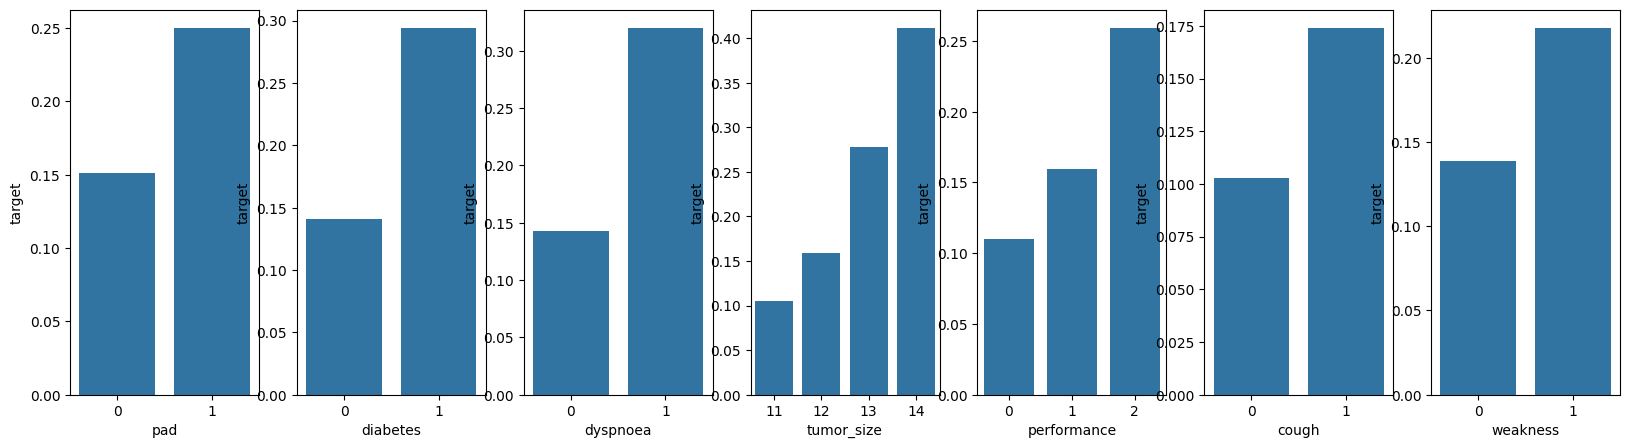

In [11]:
fig,ax = plt.subplots( nrows = 1 , ncols = 7, figsize = (20,5) )




sns.barplot( df.groupby( 'pad')['target'].mean(), ax = ax[0])
sns.barplot( df.groupby( 'diabetes')['target'].mean(), ax = ax[1] )
sns.barplot( df.groupby( 'dyspnoea')['target'].mean(), ax = ax[2] )
sns.barplot( df.groupby( 'tumor_size')['target'].mean(), ax = ax[3] )
sns.barplot( df.groupby( 'performance')['target'].mean(), ax = ax[4] )
sns.barplot( df.groupby( 'cough')['target'].mean(), ax = ax[5] )
sns.barplot( df.groupby( 'weakness')['target'].mean(), ax = ax[6] )



In [7]:
# first dummy model 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

X_train, X_test, y_train, y_test = train_test_split(Xdf, ydf, shuffle=True,  test_size=0.33, random_state=12, stratify = ydf)
clf = LogisticRegression(random_state=10, class_weight= 'balanced',  penalty='l2',  max_iter =2500 )
clf.fit(X_train, y_train)

y_pred = clf.predict( X_test )

print('accuracy ', accuracy_score(y_test, y_pred))
m = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=m,display_labels=clf.classes_).plot()


In [9]:
ydf, Xdf =  df['target'], df.drop( ['asthma', 'mi_6months', 'target'], axis = 1 )
Xdf['tumor_size'] = Xdf['tumor_size']-11
Xdf['fvc'] = (Xdf['fvc'] - Xdf['fvc'].mean())/Xdf['fvc'].std()
Xdf['fev1'] = (Xdf['fev1'] - Xdf['fev1'].mean())/Xdf['fev1'].std()
Xdf['age'] = (Xdf['age'] - Xdf['age'].mean())/Xdf['age'].std()

#Xdf = Xdf[ [  'fvc', 'diagnosis', 'tumor_size', 'dyspnoea','tumor_size','performance','weakness', 'diagnosis'] ]
  
Xdf = Xdf[[ 'performance', 'tumor_size', 'diagnosis' ] ]
X_train, X_test, y_train, y_test = train_test_split(Xdf, ydf, shuffle=True,  test_size=0.33, random_state=12, stratify = ydf)


accuracy  0.5866666666666667


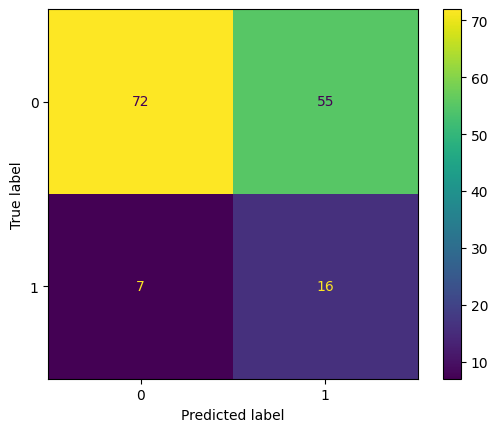

In [23]:
clf = LogisticRegression(random_state=10, class_weight= 'balanced',  penalty='l2',  max_iter =2500 )
clf.fit(X_train, y_train)

y_pred = clf.predict( X_test )

print('accuracy ', accuracy_score(y_test, y_pred))
m = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=m,display_labels=clf.classes_).plot()


accuracy  0.5933333333333334


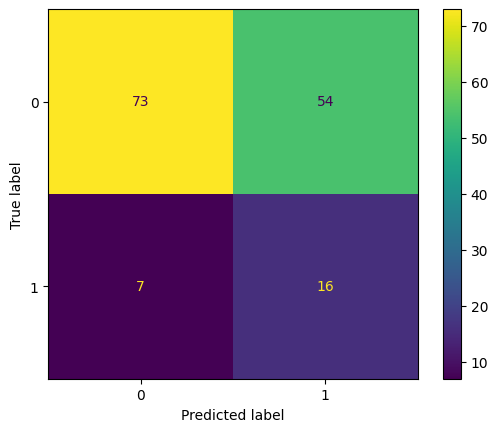

In [25]:
from imblearn.over_sampling import RandomOverSampler


from imblearn.over_sampling import SMOTE, ADASYN
X_resampled, y_resampled = SMOTE( k_neighbors = 2).fit_resample(X_train, y_train)

#X_resampled, y_resampled = RandomOverSampler( ).fit_resample(X_train, y_train)

#X_resampled, y_resampled = ADASYN( n_neighbors =2 ).fit_resample(X_train, y_train)


#ros = RandomOverSampler(random_state=0)
#X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

clf = LogisticRegression(random_state=10,  class_weight= 'balanced', penalty='l2',  max_iter =2500 )
clf.fit(X_resampled, y_resampled)

y_pred = clf.predict( X_test )

print('accuracy ', accuracy_score(y_test, y_pred))
m = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=m,display_labels=clf.classes_).plot()



accuracy  0.6192052980132451


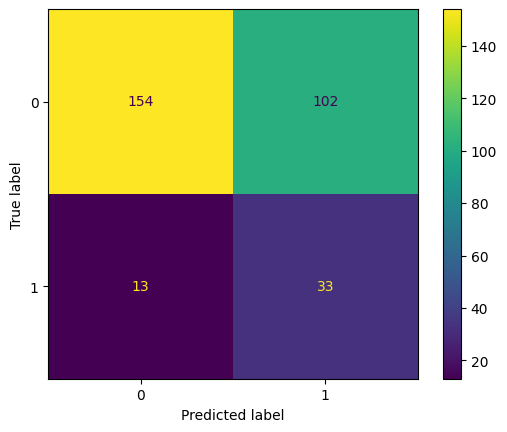

In [278]:
#Xdf = Xdf[[ 'performance', 'tumor_size', 'symptoms_count','diagnosis' ] ]


X_train, X_test, y_train, y_test = train_test_split(Xdf, ydf, shuffle=True,  test_size=0.33, random_state=12, stratify = ydf)
from imblearn.over_sampling import SMOTE, ADASYN
X_resampled, y_resampled = SMOTE( k_neighbors = 5).fit_resample(X_train, y_train)


clf = LogisticRegression(random_state=10, class_weight={ 0:1, 1:1.15}, penalty=None,  max_iter =2500 )
clf.fit(X_resampled, y_resampled)

y_pred = clf.predict( X_train )

print('accuracy ', accuracy_score(y_train, y_pred))
m = confusion_matrix(y_train, y_pred)
ConfusionMatrixDisplay(confusion_matrix=m,display_labels=clf.classes_).plot()



accuracy  0.7266666666666667


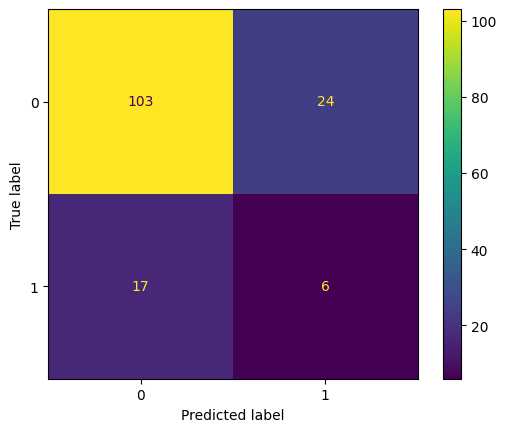

In [14]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators= 100,  max_depth=2, random_state=0)
clf.fit(X_resampled, y_resampled)
y_pred = clf.predict( X_test ) 
print('accuracy ', accuracy_score(y_test, y_pred))
m = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=m,display_labels=clf.classes_).plot()


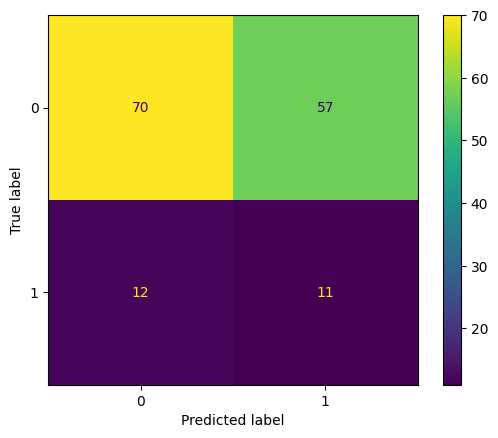

In [245]:
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
bagging = BaggingClassifier(KNeighborsClassifier(),
                            max_samples=0.5, max_features=0.5)

fit = bagging.fit( X_resampled, y_resampled) 
predict = fit.predict( X_test )
m = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=m,display_labels=clf.classes_).plot()


In [251]:
9 14 3 0   performance tumor_size symptoms_count diagnosis
X_train


,diagnosis,fvc,fev1,performance,pain,haemoptysis,dyspnoea,cough,weakness,tumor_size,diabetes,pad,smoking,age,symptoms_count,cal
392,4,0.334172,0.126299,1,0,0,0,1,0,2,0,0,1,0.613303,2,1.369231
292,1,0.615689,0.392130,0,0,0,0,0,0,1,0,0,1,-0.100550,1,1.357143
442,2,0.944125,-0.352197,1,0,0,1,1,0,1,0,0,0,-0.219525,2,1.821429
443,3,0.991044,0.923793,2,0,0,0,1,1,0,0,0,0,1.565107,2,1.287500
65,3,-0.463460,0.126299,1,0,0,0,1,0,1,0,0,0,-1.052354,1,1.107692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309,3,-1.519149,-1.242731,1,0,0,0,0,1,0,0,0,1,1.684082,2,1.261146
461,3,-1.683367,-1.256023,1,1,1,0,1,0,1,0,0,0,1.089205,3,1.179487
46,3,1.037964,1.030125,1,0,0,0,1,0,1,0,0,1,0.494328,2,1.268293
21,4,0.052654,0.445296,0,0,0,0,0,0,1,0,0,1,-0.100550,1,1.169014


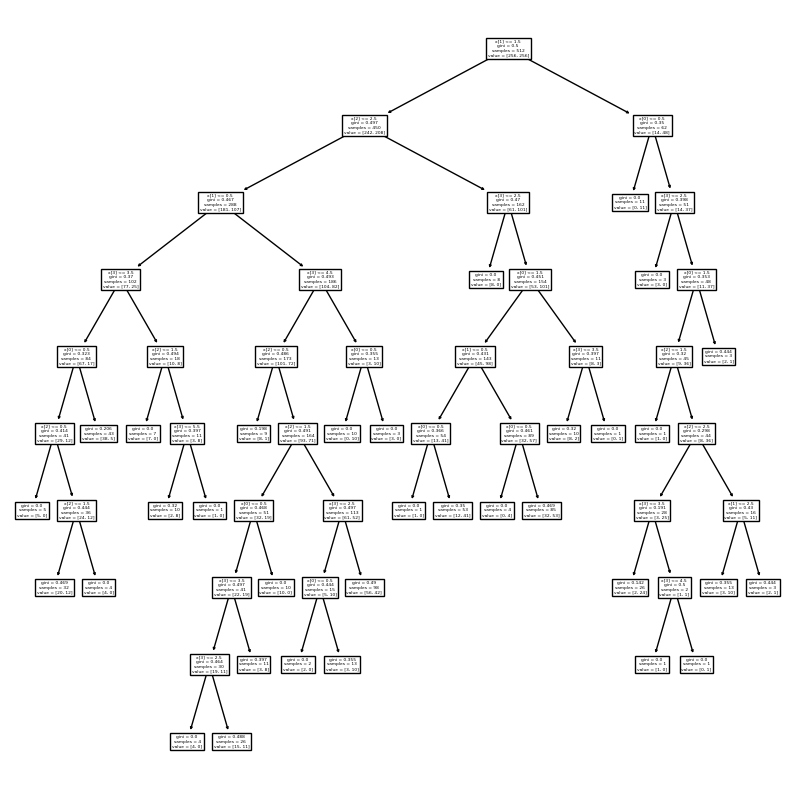

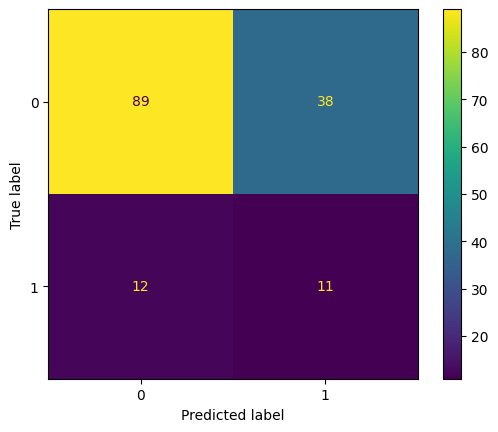

In [259]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

clf = DecisionTreeClassifier(max_leaf_nodes=33, random_state=0)
clf.fit(X_resampled, y_resampled)

gix,ax = plt.subplots( figsize= (10,10) )
_=tree.plot_tree(clf, ax =ax )

predict = clf.predict( X_test )
m = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=m,display_labels=clf.classes_).plot()


0.6866666666666666


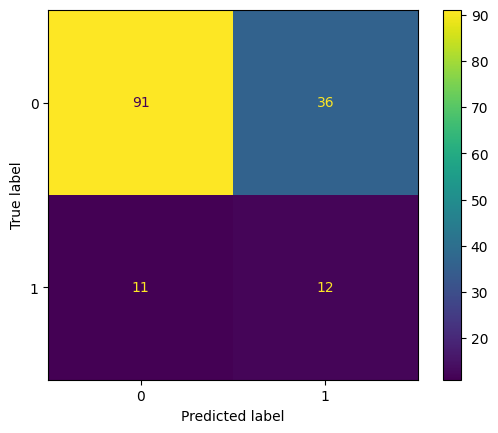

In [246]:



ridge_classifier = RidgeClassifier(class_weight ={1:5.0, 0:1},   max_iter =1000)
ridge_classifier.fit(X_train, y_train)
y_pred = ridge_classifier.predict( X_test )
accuracy = accuracy_score(y_test, y_pred)

print( accuracy )
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
m = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=m,
                              display_labels=ridge_classifier.classes_)
disp.plot()

In [118]:
y_test

308    0
40     1
348    1
344    0
160    0
      ..
109    0
320    0
5      0
46     0
164    0
Name: target, Length: 113, dtype: int32

In [123]:
y_pred.max()

0

In [19]:

df['cal'] = df['fvc']/df['fev1']
ydf, Xdf =  df['target'], df.drop( ['asthma', 'mi_6months', 'target'], axis = 1 )
  

cv_results  = cross_validate(RidgeClassifier(), Xdf, ydf, cv=3, scoring=('accuracy'),return_train_score=True)


test_scores, train_scores = cv_results['test_score'], cv_results['train_score']
print( test_scores, test_scores.mean() )
print( train_scores, train_scores.mean() )



[0.85350318 0.84713376 0.84615385] 0.8489302629430018
[0.84984026 0.85303514 0.85350318] 0.8521261946914661
